In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

In [10]:
directories = [
    "simulated_simple_broad_bursts_v4",
    "simulated_simple_narrow_bursts_v4",
    "simulated_scattered_bursts_v4",
    "simulated_complex_bursts_v4",
    "simulated_drifting_bursts_v4"
]

data = []

for directory in directories:
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            data_per_directory.append(np.load(os.path.join(data_dir, filename)))

    data_per_directory = np.array(data_per_directory).reshape(-1, 1024 * 512)[:100]
    data.append(data_per_directory)

# Combine the data from all directories into one array
combined_data = np.concatenate(data, axis=0)

# Reshape the combined data for PCA
combined_data_2d = combined_data.reshape(-1, 1024 * 512)

print(combined_data_2d.shape)


In [13]:
print(combined_data_2d.shape)


(500, 524288)


In [11]:
# Apply PCA to the combined data
n_components = 2  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(combined_data_2d)
transformed_fit = pca.fit_transform(combined_data_2d)



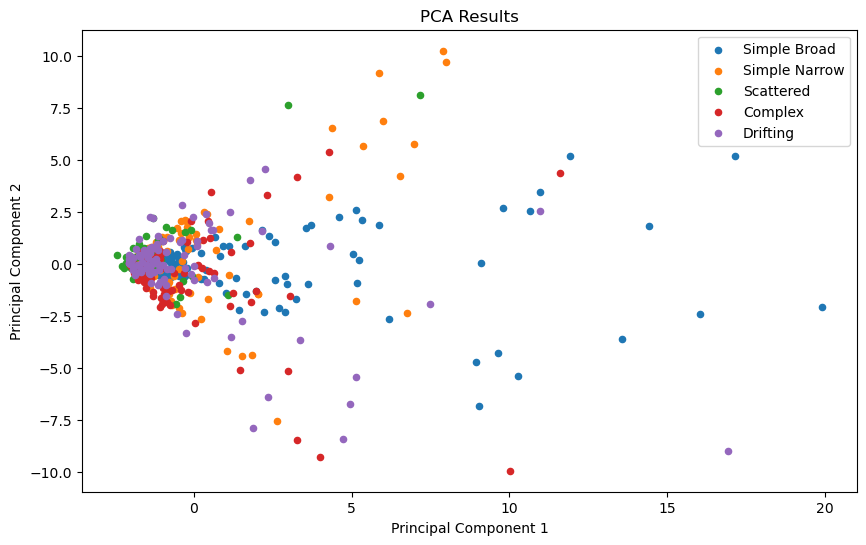

In [14]:
# Define labels for each directory
labels = [
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot where points are colored by directory labels
for i, label in enumerate(directories):
    num_samples = data[i].shape[0]
    start_idx = sum(len(data[j]) for j in range(i))
    end_idx = start_idx + num_samples
    plt.scatter(transformed_fit[start_idx:end_idx, 0], transformed_fit[start_idx:end_idx, 1], label=labels[i], s=20)

# Set axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set a title for the plot
plt.title('PCA Results')

# Display a legend to differentiate the datasets
plt.legend()

# Show the plot
plt.show()

In [15]:
# Apply PCA to the combined data
n_components = 3  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(combined_data_2d)
transformed_fit = pca.fit_transform(combined_data_2d)


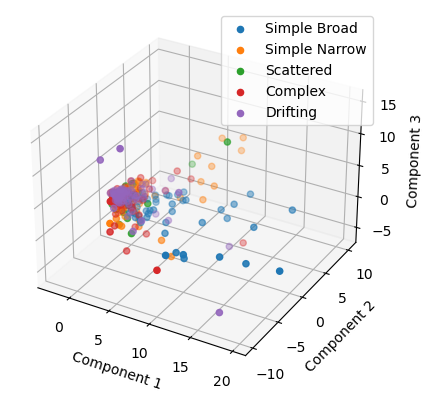

In [18]:
# Separate the transformed data back into classes
pca_per_directory = []
for i in range(len(directories)):
    num_samples = data[i].shape[0]
    start_idx = sum(len(data[j]) for j in range(i))
    end_idx = start_idx + num_samples
    pca_per_directory.append(transformed_fit[start_idx:end_idx, :])

# Create a 3D scatter plot for each class
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
]


for i, label in enumerate(directories

):
    ax.scatter(pca_per_directory[i][:, 0], pca_per_directory[i][:, 1], pca_per_directory[i][:, 2], label=labels[i])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend()
plt.show()

## Look at the PCA representation for each component

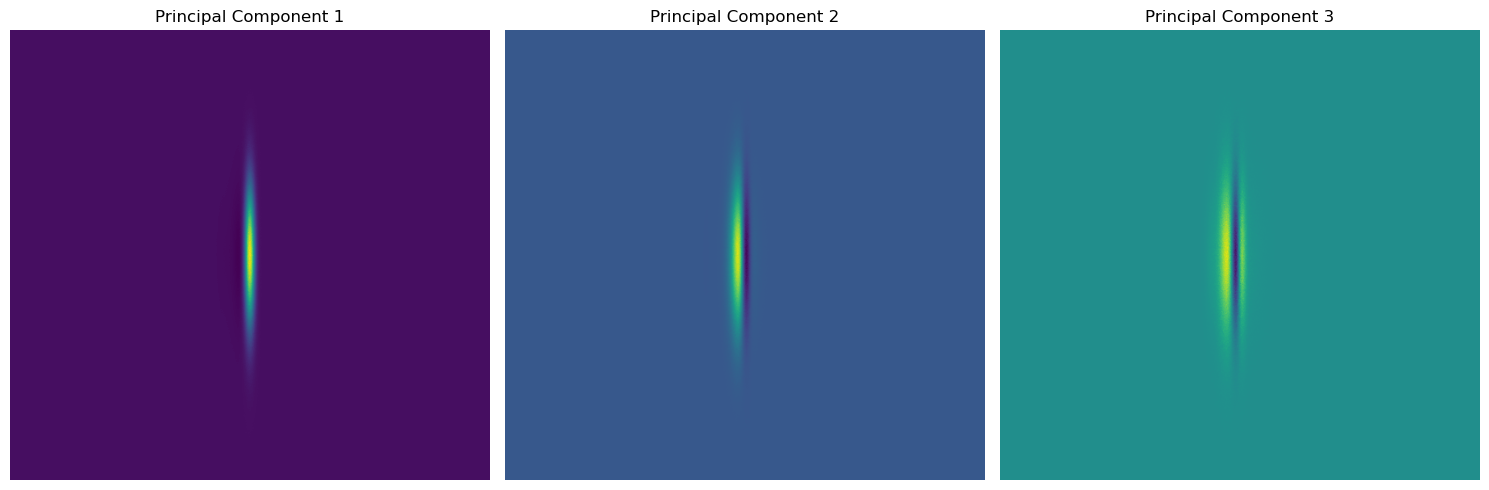

In [24]:
# Get the principal components
principal_components = pca.components_

# Create a subplot for each principal component
n_cols = 3  # Number of columns for subplots
n_rows = 1  # Number of rows for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))

# Plot each principal component
for i in range(n_components):
    component = principal_components[i].reshape(1024, 512)
    ax = axes[i]
    ax.imshow(component.T, cmap='viridis', aspect='auto')
    ax.set_title(f'Principal Component {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Look at explained variance as a function of the number of components

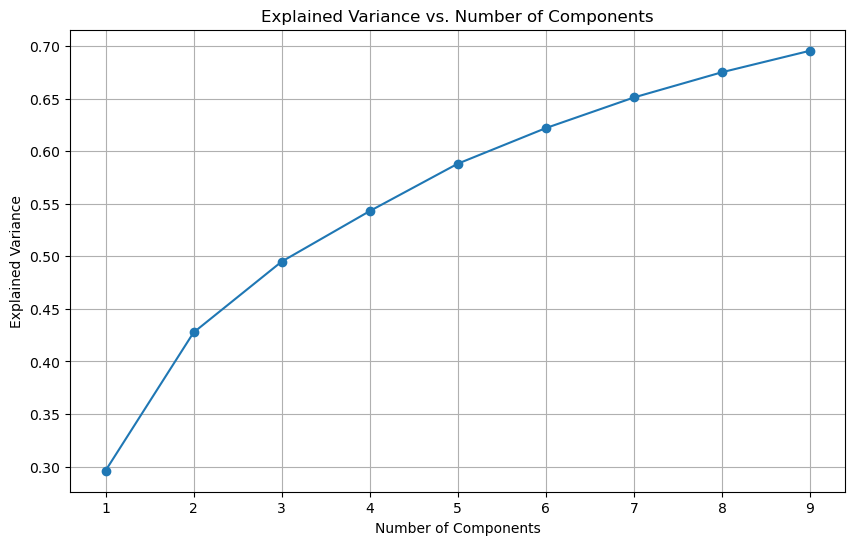

In [19]:
explained_variance = []

for n in range(1, 10):
    pca = PCA(n_components=n)
    pca.fit(combined_data_2d)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variance as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

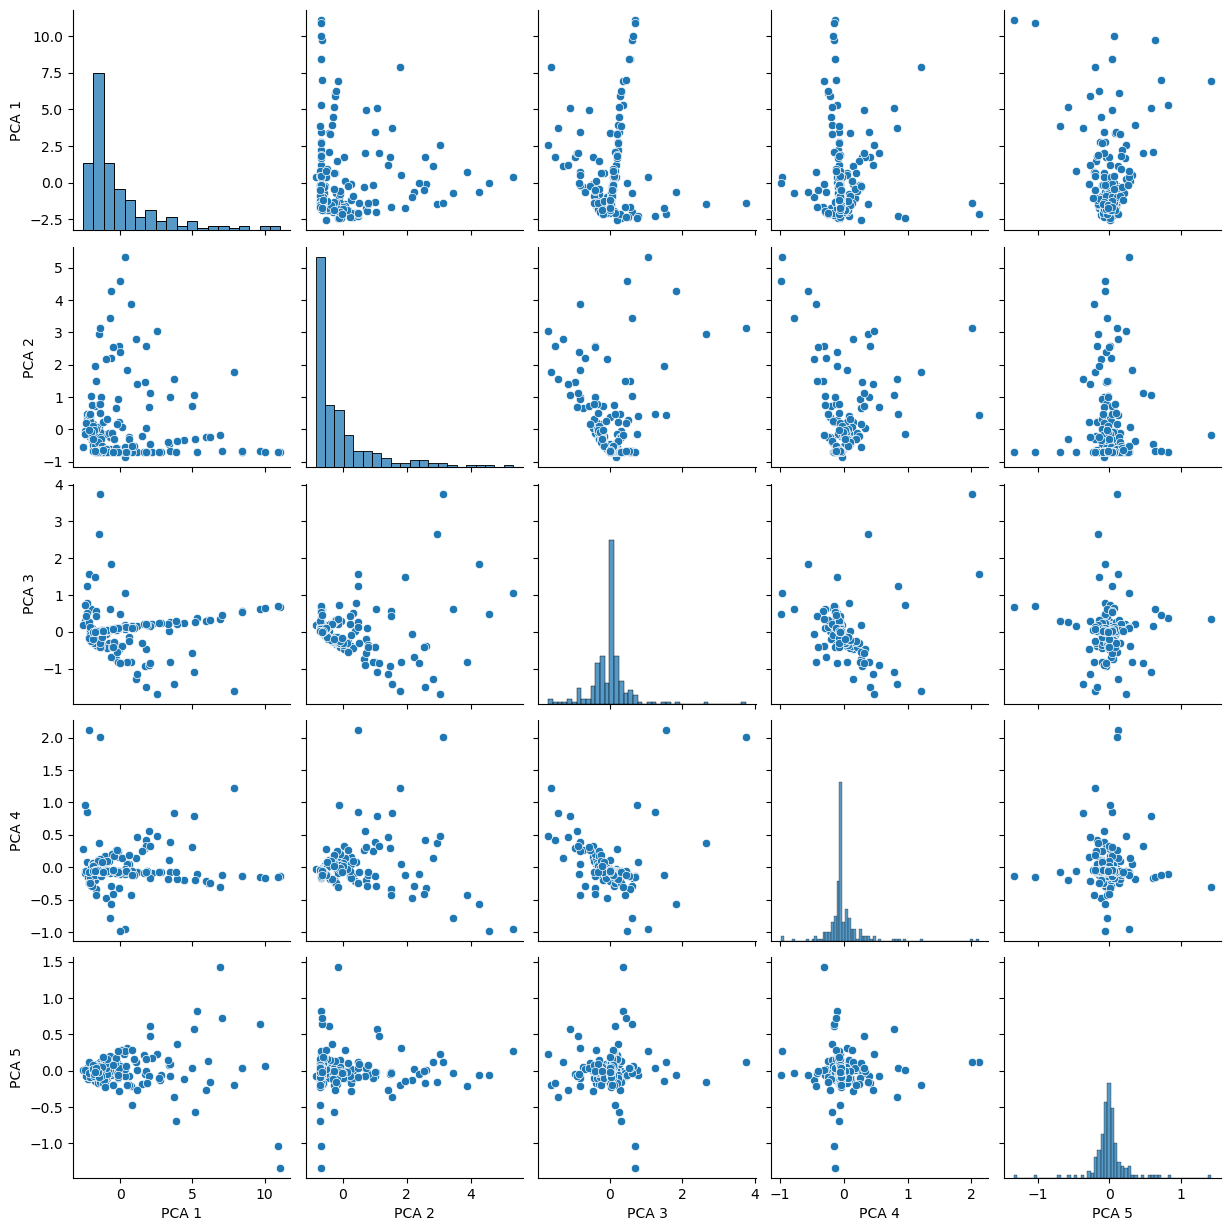

In [10]:
# Fit PCA with 5 components
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(combined_data_2d)

# Transform data to the first 5 PCA components
transformed_data = pca.transform(combined_data_2d)

# Create a DataFrame with the transformed data
pca_df = pd.DataFrame(transformed_data, columns=[f"PCA {i + 1}" for i in range(n_components)])

# Create a pairplot
sns.pairplot(pca_df)
plt.show()
